In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
from pyvbmc import VBMC
import corner


from scipy.integrate import quad
from tied_utils import tied_data_gen_wrapper, rho_E_minus_small_t_NORM_TIED_fn, rho_E_plus_small_t_NORM_TIED_fn, rho_E_small_t_NORM_TIED_fn


In [2]:
# read out_LED.csv as dataframe
og_df = pd.read_csv('../out_LED.csv')

# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

In [3]:
# find ABL and ILD
ABL_arr = df['ABL'].unique()
ILD_arr = df['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)

print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

ABL: [20 40 60]
ILD: [-16.  -8.  -4.  -2.  -1.   1.   2.   4.   8.  16.]


In [4]:
# LED off rows
df_1 = df[ df['LED_trial'] == 0 ]
# animal rows
animal = 100
df_1 = df_1[ df_1['animal'] == animal ]
print(f' len of df_1 {len(df_1)}')

 len of df_1 6227


simulated data instead of real data

In [5]:
rate_lambda_sim = 0.076
theta_E_sim =  50.7
T_0_sim = 0.19 * (1e-3)
t_non_decision_sim = 78 * (1e-3)


t_stim_0 = 0.2
t_stim_scale = 0.4

N_print = int(5e3)
dt = 1e-4

N_sim = int(50e3)
df_1 = Parallel(n_jobs = -1)( delayed(tied_data_gen_wrapper)(ILD_arr, ABL_arr, rate_lambda_sim, theta_E_sim, T_0_sim, t_non_decision_sim, \
                                                             t_stim_0, t_stim_scale, num_iter, N_print, dt) for num_iter in range(N_sim))

Iter # 0, ILD: 1.0, ABL: 40, t_stim: 0.31923400626720155
Iter # 5000, ILD: 8.0, ABL: 60, t_stim: 0.43183608204415297
Iter # 10000, ILD: -1.0, ABL: 60, t_stim: 0.8991954620833071
Iter # 15000, ILD: 2.0, ABL: 20, t_stim: 0.8851801519126703
Iter # 20000, ILD: 16.0, ABL: 20, t_stim: 0.7361808985771576
Iter # 25000, ILD: -4.0, ABL: 60, t_stim: 0.5029107958275802
Iter # 30000, ILD: 16.0, ABL: 20, t_stim: 0.4120348513257149
Iter # 40000, ILD: 8.0, ABL: 60, t_stim: 0.5360889053146927
Iter # 35000, ILD: 16.0, ABL: 20, t_stim: 0.5457313619625901
Iter # 45000, ILD: -4.0, ABL: 20, t_stim: 0.5308169196185921


# VBMC

## timed fix trunc factor and rt factor

In [6]:
T_trunc_timed_fix = 0

## loglike

In [ ]:
def compute_loglike(row, rate_lambda, theta_E, T_0, t_non_decision):
    # for real data
    # timed_fix = row['timed_fix']
    # intended_fix = row['intended_fix']

    # choice = row['response_poke']
    # rt = timed_fix - intended_fix

    # for simulated data
    rt = row['rt']
    choice = row['choice']

    if choice == 1:
        choice = 3
    elif choice == -1:
        choice = 2
        
    ILD = row['ILD']
    ABL = row['ABL']

    
     
    
    K_max = 10

    # change units back to seconds from ms
    T_0 *= 1e-3
    t_non_decision *= 1e-3

    area_from_t_trunc_to_inf = quad(rho_E_small_t_NORM_TIED_fn, T_trunc_timed_fix, 10, args=(ILD, ABL, rate_lambda, theta_E, T_0, t_non_decision, K_max))[0]

    if area_from_t_trunc_to_inf == 0:
        area_from_t_trunc_to_inf = 1e-50
        
    trunc_factor = 1 / area_from_t_trunc_to_inf 
        

    # TEMP
    trunc_factor = 1

    if choice == 3:
        likelihood = rho_E_plus_small_t_NORM_TIED_fn(rt, ILD, ABL, rate_lambda, theta_E, T_0, t_non_decision, K_max) * trunc_factor
    elif choice == 2:
        likelihood = rho_E_minus_small_t_NORM_TIED_fn(rt, ILD, ABL, rate_lambda, theta_E, T_0, t_non_decision, K_max) * trunc_factor
    
    if rt < T_trunc_timed_fix:
        likelihood = 0

    if likelihood <= 0:
        likelihood = 1e-50

    
    return np.log(likelihood)    


def tied_loglike_fn(params):
    rate_lambda, theta_E, T_0, t_non_decision = params

    all_loglike = Parallel(n_jobs=-1)(
                                     delayed(compute_loglike)(row, rate_lambda, theta_E, T_0, t_non_decision)\
                                        # for _, row in df_1.iterrows() 
                                        # if ( (row['response_poke'] in [2,3])  and (row['timed_fix'] > T_trunc_timed_fix) and (row['timed_fix'] > row['intended_fix']) \
                                        #     and (row['timed_fix'] <= 1) )
                                        for row in df_1
                                        # if (row['rt'] > T_trunc_timed_fix) and (row['rt'] <= 1)
                                    )

    loglike = np.sum(all_loglike)
    # if loglike is nan , stop the process
    if np.isnan(loglike):
        print('nan loglike')
        
    return loglike

## Bounds

In [8]:
# Bounds that are not working

# rate_lambda_bounds = [0.01, 0.2]
# T_0_bounds = [0.1, 0.8] #  ms
# theta_E_bounds = [35, 65]
# t_non_decision_bounds = [60, 90] # ms

# rate_lambda_plausible_bounds =  [0.05, 0.09]
# T_0_plausible_bounds = [0.15, 0.5] #  ms
# theta_E_plausible_bounds = [40, 55]
# t_non_decision_plausible_bounds = [70, 80] # ms

rate_lambda_bounds = [0.01, 0.2]
T_0_bounds = [0.05, 1.2]
theta_E_bounds = [20, 80]
t_non_decision_bounds = [40, 100]

rate_lambda_plausible_bounds =  [0.07, 0.15]
T_0_plausible_bounds = [0.2, 0.9]
theta_E_plausible_bounds = [40, 60]
t_non_decision_plausible_bounds = [55, 90]

## prior

In [9]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def tied_prior_fn(params):
    rate_lambda, theta_E, T_0, t_non_decision = params

    rate_lambda_logpdf = trapezoidal_logpdf(rate_lambda, rate_lambda_bounds[0], rate_lambda_plausible_bounds[0], \
                                            rate_lambda_plausible_bounds[1], rate_lambda_bounds[1])
    theta_E_logpdf = trapezoidal_logpdf(theta_E, theta_E_bounds[0], theta_E_plausible_bounds[0], \
                                            theta_E_plausible_bounds[1], theta_E_bounds[1])
    T_0_logpdf = trapezoidal_logpdf(T_0, T_0_bounds[0], T_0_plausible_bounds[0], \
                                            T_0_plausible_bounds[1], T_0_bounds[1])
    t_non_decision_logpdf = trapezoidal_logpdf(t_non_decision, t_non_decision_bounds[0], t_non_decision_plausible_bounds[0], \
                                            t_non_decision_plausible_bounds[1], t_non_decision_bounds[1])
    
    return rate_lambda_logpdf + theta_E_logpdf + T_0_logpdf + t_non_decision_logpdf

## prior + likelihood

In [10]:
def tied_joint_fn(params):
    return tied_loglike_fn(params) + tied_prior_fn(params)

## run vbmc

In [ ]:
lb = np.array([rate_lambda_bounds[0], theta_E_bounds[0], T_0_bounds[0], t_non_decision_bounds[0]])
ub = np.array([rate_lambda_bounds[1], theta_E_bounds[1], T_0_bounds[1], t_non_decision_bounds[1]])
plb = np.array([rate_lambda_plausible_bounds[0], theta_E_plausible_bounds[0], T_0_plausible_bounds[0], t_non_decision_plausible_bounds[0]])
pub = np.array([rate_lambda_plausible_bounds[1], theta_E_plausible_bounds[1], T_0_plausible_bounds[1], t_non_decision_plausible_bounds[1]])

np.random.seed(42)
rate_lambda_0 = np.random.uniform(rate_lambda_plausible_bounds[0], rate_lambda_plausible_bounds[1])
theta_E_0 = np.random.uniform(theta_E_plausible_bounds[0], theta_E_plausible_bounds[1])
T_0_0 = np.random.uniform(T_0_plausible_bounds[0], T_0_plausible_bounds[1])
t_non_decision_0 = np.random.uniform(t_non_decision_plausible_bounds[0], t_non_decision_plausible_bounds[1])

x0 = np.array([rate_lambda_0, theta_E_0, T_0_0, t_non_decision_0])

vbmc = VBMC(tied_joint_fn, x0, lb, ub, plb, pub, options={'display': 'on'})
vp, results = vbmc.optimize()

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 4).
Reshaping upper bounds to (1, 4).
Reshaping plausible lower bounds to (1, 4).
Reshaping plausible upper bounds to (1, 4).
Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action


In [ ]:
vp.save('tied_vp.pkl', overwrite=True)

In [ ]:
# import pickle
# with open('tied_vp.pkl', 'rb') as f:
#     vp_results = pickle.load(f)

## corner plots

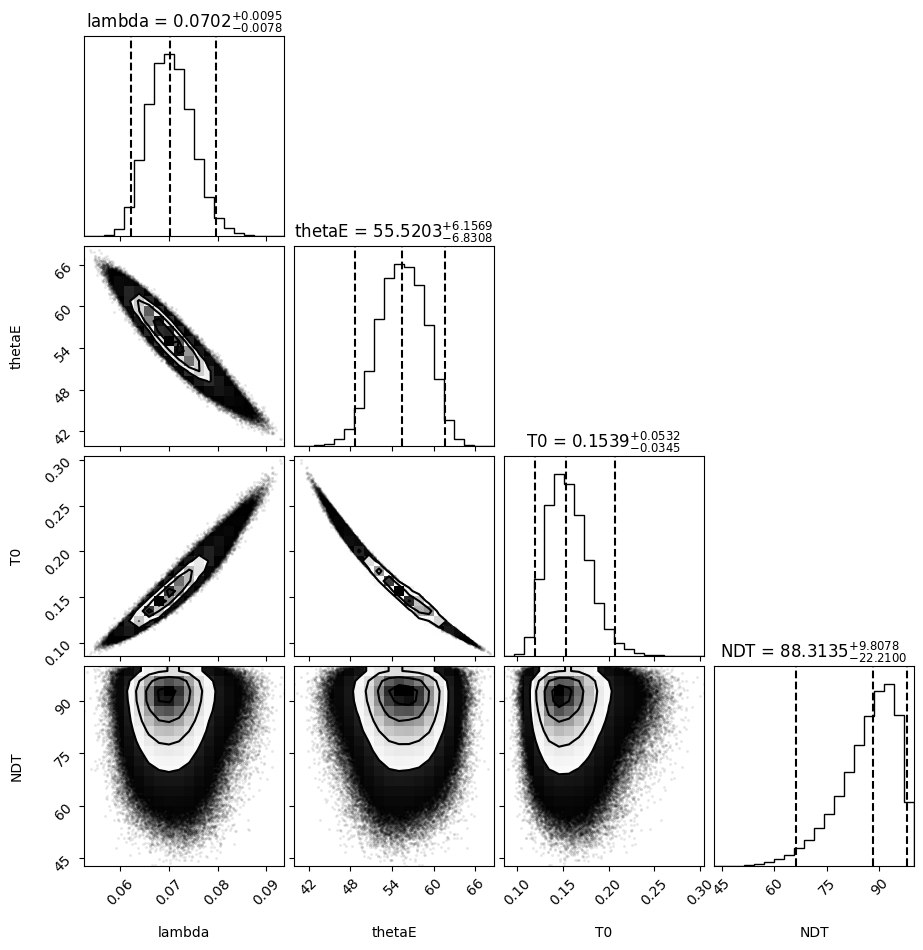

In [ ]:
vp_samples = vp.sample(int(1e6))[0]

rate_lambda_samp = vp_samples[:, 0]
theta_E_samp = vp_samples[:, 1]
T_0_samp = vp_samples[:, 2]
t_non_decision_samp = vp_samples[:, 3]

combined_samples = np.transpose(np.vstack((rate_lambda_samp, theta_E_samp, T_0_samp, t_non_decision_samp)))
param_labels = ['lambda', 'thetaE', 'T0', 'NDT']

corner.corner (combined_samples, labels=param_labels, show_titles=True, quantiles=[0.025, 0.5, 0.975], title_fmt=".4f"  );


In [ ]:
vp_samples[:,0].mean(), vp_samples[:,1].mean(), vp_samples[:,2].mean(), vp_samples[:,3].mean()

NameError: name 'vp_samples' is not defined

# Correlation btn params

Text(0, 0.5, 'T_0')

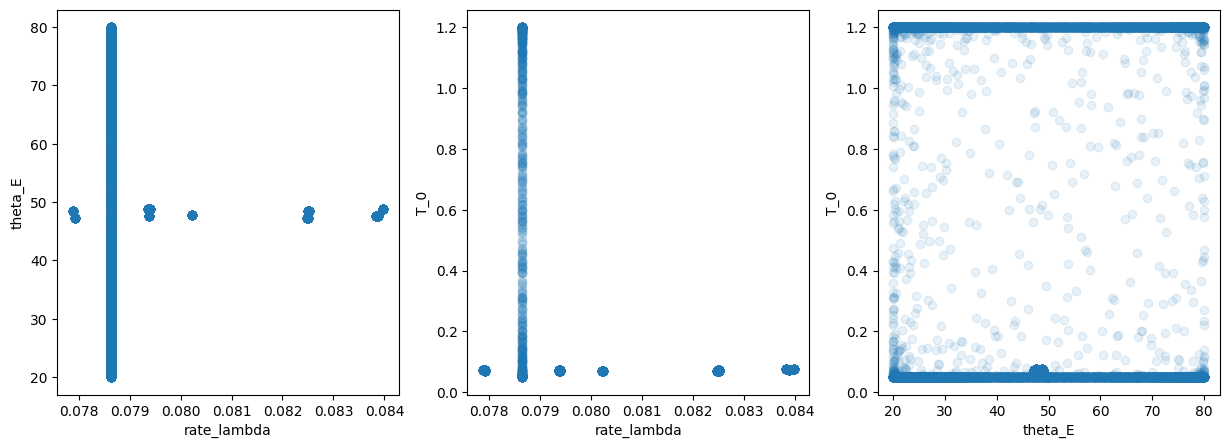

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(vp_samples[:, 0], vp_samples[:, 1], 'o', alpha=0.1)
plt.xlabel('rate_lambda')
plt.ylabel('theta_E')

plt.subplot(1,3,2)
plt.plot(vp_samples[:, 0], vp_samples[:, 2], 'o', alpha=0.1)
plt.xlabel('rate_lambda')
plt.ylabel('T_0')

plt.subplot(1,3,3)
plt.plot(vp_samples[:, 1], vp_samples[:, 2], 'o', alpha=0.1)
plt.xlabel('theta_E')
plt.ylabel('T_0')


# mean vp param

In [ ]:
# get mean of samples
mean_vb_params = {}
for i, label in enumerate(param_labels):
    mean_vb_params[label] = np.mean(vp_samples[:, i])

mean_vb_params['T0'] = mean_vb_params['T0'] * 1e-3 # s
mean_vb_params['NDT'] = mean_vb_params['NDT'] * 1e-3 # s

# diagnostics

In [ ]:
# t_stim_0 = 0.2
# t_stim_tau = 0.4
# N_print = int(1e5)
# N_sim = int(1e6)
# dt = 1e-4

# sim_results = Parallel(n_jobs=-1)(delayed(tied_data_gen_wrapper)(ILD_arr, ABL_arr, \
#                                                                  mean_vb_params['lambda'], mean_vb_params['thetaE'], mean_vb_params['T0'], mean_vb_params['NDT'], \
#                                                                   t_stim_0, t_stim_tau, iter_num, N_print, dt
#                                                                 )

#                                                                         for iter_num in range(N_sim) 
#                                                                         )

# Is likelihood working correctly?

lambda_1: 0.03376293541054098, thetaE_1: 60.916230248006464, T0_1: 0.0006422077693254213, NDT_1: 0.043751811490836345
area: 0.907926347876364
trunc_factor: 1.1014109264908942


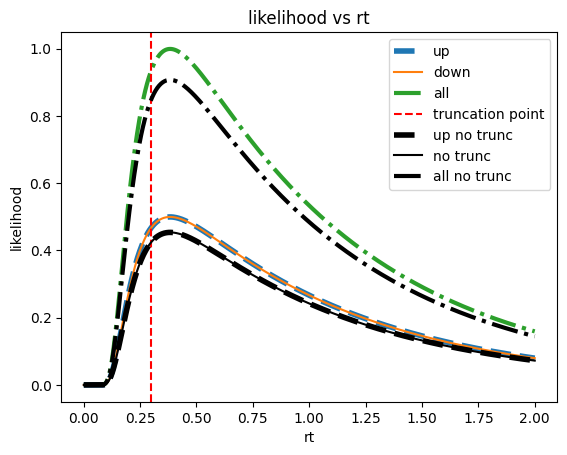

In [ ]:


t_pts = np.linspace(0.001, 2, 1000)

lambda_1 = np.random.uniform(rate_lambda_bounds[0], rate_lambda_bounds[1])
thetaE_1 = np.random.uniform(theta_E_bounds[0], theta_E_bounds[1])
T0_1 = np.random.uniform(T_0_bounds[0], T_0_bounds[1])
NDT_1 = np.random.uniform(t_non_decision_bounds[0], t_non_decision_bounds[1])

T0_1 *= 1e-3
NDT_1 *= 1e-3
print(f'lambda_1: {lambda_1}, thetaE_1: {thetaE_1}, T0_1: {T0_1}, NDT_1: {NDT_1}')

ABL = 40; ILD = 0

K_max = 10

area = quad(rho_E_small_t_NORM_TIED_fn,T_trunc_timed_fix, 10, args=(ILD, ABL, lambda_1, thetaE_1, T0_1, NDT_1, K_max))[0]
print(f'area: {area}')
try:
    trunc_factor = 1 / (area) 
except Exception as e:
    print('is it')
    trunc_factor = 0

print(f'trunc_factor: {trunc_factor}')
# trunc_factor = 1

up_like = np.array([rho_E_plus_small_t_NORM_TIED_fn(rt, ILD, ABL, lambda_1, thetaE_1, T0_1, NDT_1,  K_max) * trunc_factor for rt in t_pts])
down_like = np.array([rho_E_minus_small_t_NORM_TIED_fn(rt, ILD, ABL, lambda_1, thetaE_1, T0_1, NDT_1, K_max) * trunc_factor for rt in t_pts])
all_like = np.array([rho_E_small_t_NORM_TIED_fn(rt, ILD, ABL, lambda_1, thetaE_1, T0_1, NDT_1, K_max) * trunc_factor for rt in t_pts])

plt.plot(t_pts, up_like, label='up', lw=4, linestyle='--')
plt.plot(t_pts, down_like, label='down')
plt.plot(t_pts, all_like, label='all', linestyle='-.', lw=3)
plt.axvline(x=T_trunc_timed_fix, color='r', linestyle='--', label='truncation point')

plt.plot(t_pts, up_like/trunc_factor, label='up no trunc', lw=4, linestyle='--', color='k')
plt.plot(t_pts, down_like/trunc_factor, label='no trunc', color='k')
plt.plot(t_pts, all_like/trunc_factor, label='all no trunc', linestyle='-.', lw=3, color='k')

plt.xlabel('rt'); plt.ylabel('likelihood'); plt.title('likelihood vs rt');
plt.legend();